In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from scipy import stats
import scipy


from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin

import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
fileName = 'construction_material_prices_2008_2018.csv'
df = pd.read_csv(fileName)

In [3]:
df = df.rename(index=str,columns={'Unnamed: 0':'date'})
df['date'] = pd.to_datetime(df['date'])
df['month'] = df.date.dt.month
df['day'] = df.date.dt.day
df['dow'] = df.date.dt.dayofweek
df['year'] = df.date.dt.year
df['week'] = df.date.dt.week


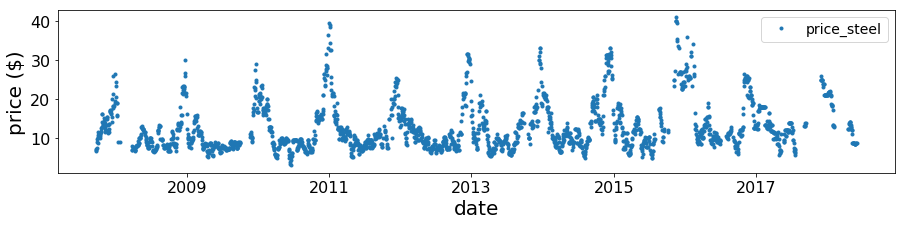

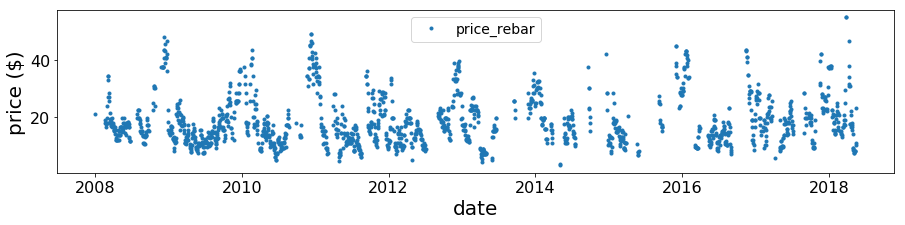

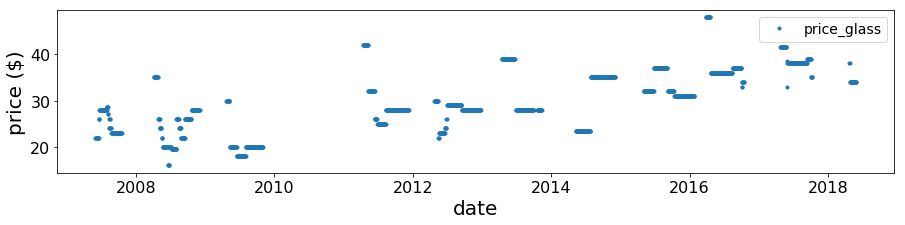

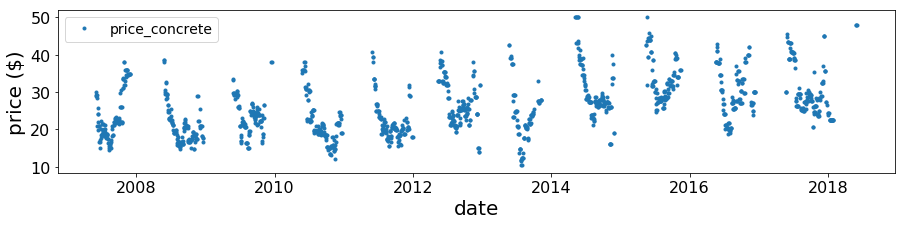

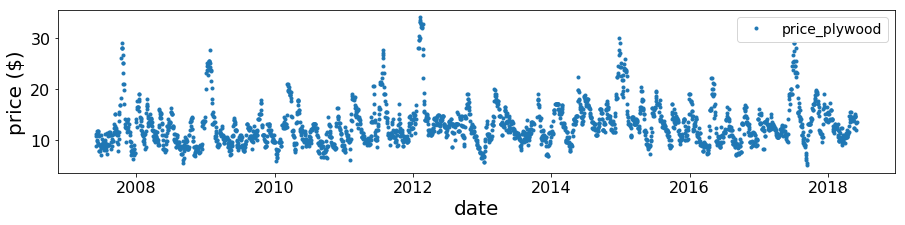

In [4]:
def plot_data(df,cols,figsize=(15,5),fontsize=20,linewidth=2,tick_fontsize=16,leg_fontsize=14,linestyle='-',marker=''):
    f1 = plt.figure(figsize=figsize)
    ax = f1.add_subplot(111)
    ax.tick_params(axis='both',labelsize=tick_fontsize)
    if type(cols)==str:
        cols = [cols]
    for col in cols:
        p = ax.plot(df.date,df[col],linewidth=linewidth,linestyle=linestyle,marker=marker)
    ax.set_xlabel('date',fontsize=fontsize)
    ax.set_ylabel('price ($)',fontsize=fontsize)
    ax.legend(cols,fontsize=leg_fontsize)
    return p  

products = ['steel','rebar','glass','concrete','plywood']
cols = ['price_' + p for p in products]

for col in cols:
    plot_data(df,col,figsize=(15,3),linestyle='none',marker='.')

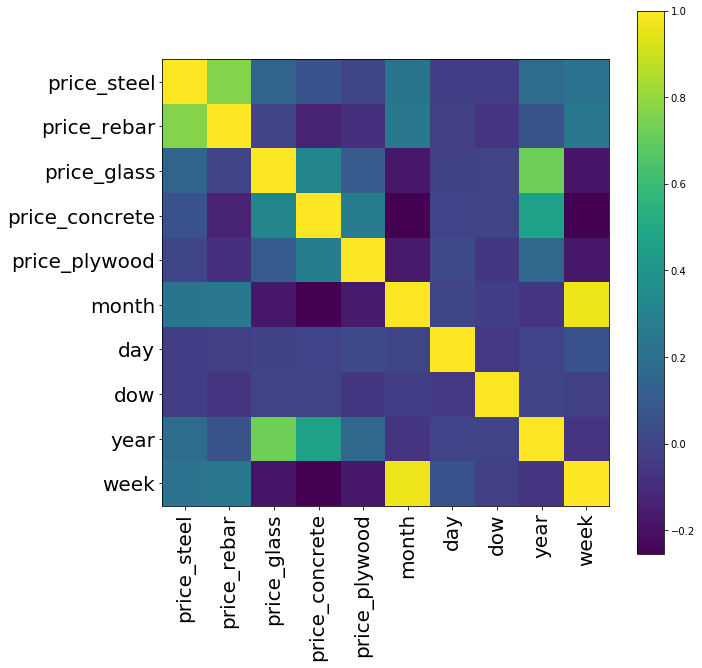

In [5]:
def plot_cov(df,cols,figsize=(10,10),fontsize=20,x_tick_rotation=90):
    if not cols:
        cols = df.columns
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(1,1,1)
    c = ax.imshow(df[cols].corr())
    ax.set_xticks(range(len(cols)))
    ax.set_yticks(range(len(cols)))
    ax.set_xticklabels(cols)
    ax.tick_params(axis='x',rotation=x_tick_rotation)
    ax.tick_params(axis='both',labelsize=fontsize)
    ax.set_yticklabels(cols)
    plt.colorbar(c)
    

cols = [c for c in df.columns if c!='date']
plot_cov(df,cols,x_tick_rotation=90)


Looking at the data, it is clear that different items have different dynamics, different amounts of missing values. The prices of steel and rebar are correlated, and also have a strong seasonal effect on price. We can use the seasonal effect and the correlation to impute missing values. The price of glass has a lot of missing values, no seasonal effect, and very infrequent changes in price. There is a trend over time, but I think the best imputation is to just to make all of the values the last value. For concrete, the monthly trend is important as is yearly trend

In [6]:
def interp_ratio(df,col1,col2,normalized=False):
    ratio = df[col1].mean()/df[col2].mean()
    if normalized:
        ratio = 1.0
    col1_nan_mask = df[col1].isnull()
    df.loc[col1_nan_mask,col1] = df.loc[col1_nan_mask,col2]*ratio
    col2_nan_mask = df[col2].isnull()
    df.loc[col2_nan_mask,col2] = df.loc[col2_nan_mask,col1]/ratio
    df[col1+'_'+col2+'_ratio'] = ratio
    return df

In [7]:

def interp_nearest(df,cols):
    x = np.array(range(len(df)))
    if type(cols) == str:
        cols = [cols]
    for col in cols:
        y = df[col]
        mask = y.notnull()
        nearest = scipy.interpolate.interp1d(x[mask],y[mask],kind='nearest',fill_value='extrapolate')
        df[col] = nearest(x)
    return df



In [8]:
class ratio_interpolator(BaseEstimator, TransformerMixin):
    def __init__(self,col1,col2,normalized=False):
        self.col1 = col1
        self.col2 = col2
        self.norm = normalized

    def transform(self,df, *_):
        return interp_ratio(df,self.col1,self.col2,normalized=self.norm)

    def fit(self, *_):
        return self

In [9]:
class nearest_interpolator(BaseEstimator, TransformerMixin):
    def __init__(self,cols):
        self.cols = cols

    def transform(self,df, *_):
        return interp_nearest(df,self.cols)

    def fit(self, *_):
        return self

In [10]:
class trend_fitter(BaseEstimator, TransformerMixin):
    def __init__(self,cols,date):
        self.cols = cols
        self.min_date = date.min()
        
    def transform(self,df, *_):
        x = np.array((df.date-self.min_date).dt.days)
        for col in self.cols:
            lm = self.lm_dict[col]
            df[col] = df[col]-(lm.intercept_ + x*lm.coef_)
            df[col+'_coef'] = lm.coef_[0]
            df[col+'_intercept'] = lm.intercept_
        return df
    
    def fit(self,df,*_):
        lm_dict = dict()
        for col in self.cols:
            lm = LinearRegression()
            mask = df[col].notnull()
            x = np.array((df.date-self.min_date).dt.days)
            lm.fit(x[mask].reshape(-1,1),df[col][mask])
            lm_dict[col] = lm
        self.lm_dict = lm_dict
        return self

In [11]:
class season_fitter(BaseEstimator, TransformerMixin):
    def __init__(self,cols,period='month'):
        self.cols = cols
        self.period = period
        
    def transform(self,df, *_):
        T = df[self.period].unique()
        for col in self.cols:
            gm = self.means_dict[col]
            for t in T:
                m = gm[t]
                df.loc[df[self.period]==t,col] = df.loc[df[self.period]==t,col]-m
                df[col+'_mo_'+str(t)] = m
        return df
    
    def fit(self,df,*_):
        means_dict = dict()
        t = sorted(df[self.period].unique())
        for col in self.cols:
            group_mean = df.groupby([self.period])[col].mean()
            
            means_dict[col] = {k:v for k,v in zip(t,group_mean)}
        self.means_dict = means_dict
        return self

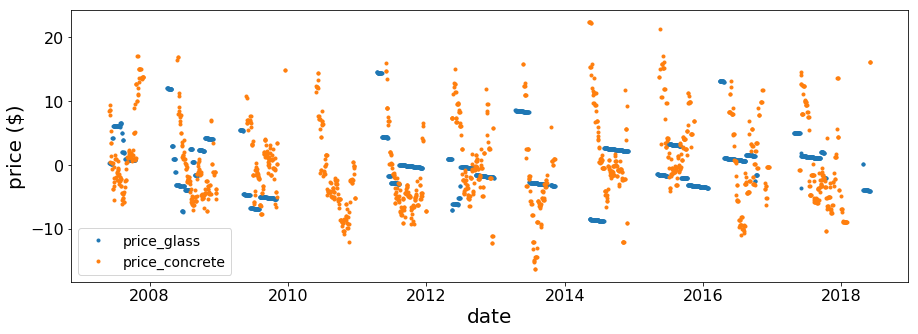

In [12]:
trend_prods = ['glass','concrete','plywood','steel','rebar']
trend_cols = ['price_' + p for p in trend_prods]
tf = trend_fitter(trend_cols,df.date)
df_ = df.copy()
df_ = tf.fit_transform(df_)
plot_data(df_,['price_glass','price_concrete'],linestyle='none',marker='.')

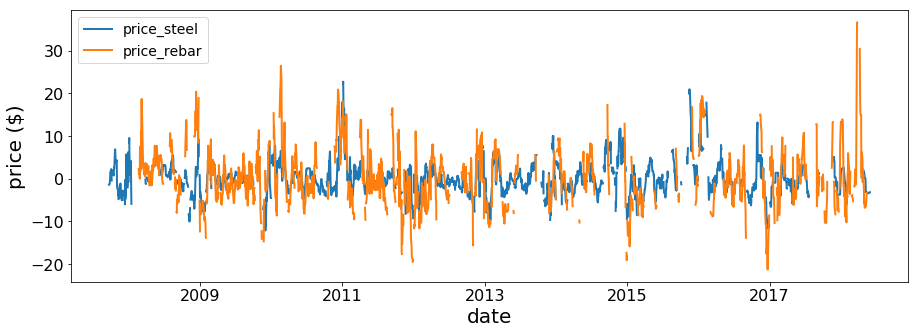

In [13]:
season_prods = ['glass','steel','rebar','concrete','plywood']
season_cols = ['price_' + p for p in season_prods]
sf = season_fitter(season_cols,period='month')
df_ = sf.fit_transform(df_)
plot_data(df_,['price_steel','price_rebar'])

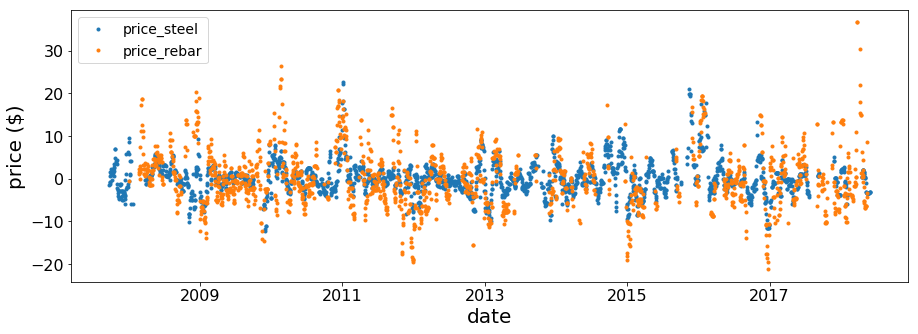

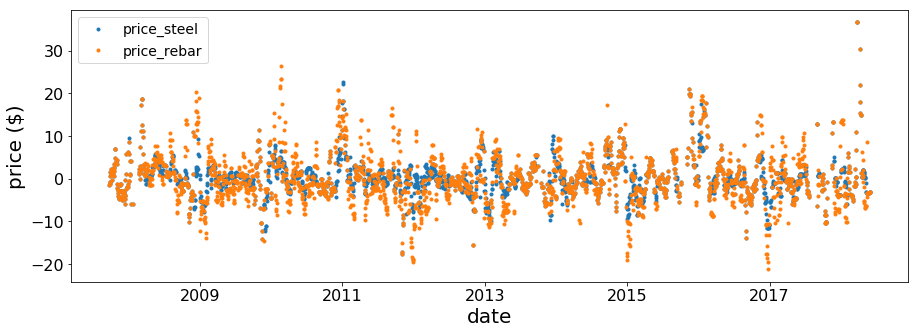

In [14]:
col1 = 'price_steel'
col2 = 'price_rebar'
ri = ratio_interpolator(col1,col2,normalized=True)
plot_data(df_,[col1,col2],linestyle='none',marker='.')
df_ = ri.transform(df_)
plot_data(df_,[col1,col2],linestyle='none',marker='.')

Everything below here is just exploratory scripting. Classes for splitting data, reformating data for prediction, and for iteratively predicting in the future need to be added.

In [15]:
split_date = 2016
train_mask = df.year<split_date
test_mask = df.year>=split_date
train_df = df.loc[train_mask]
test_df = df.loc[test_mask]
prods = ['steel','rebar','glass','concrete','plywood']
cols = ['price_' + p for p in prods]
tf = trend_fitter(cols,train_df.date)
tf.fit(train_df)
sf = season_fitter(cols,period='month')
sf.fit(train_df)
for col in cols:
    pass
    

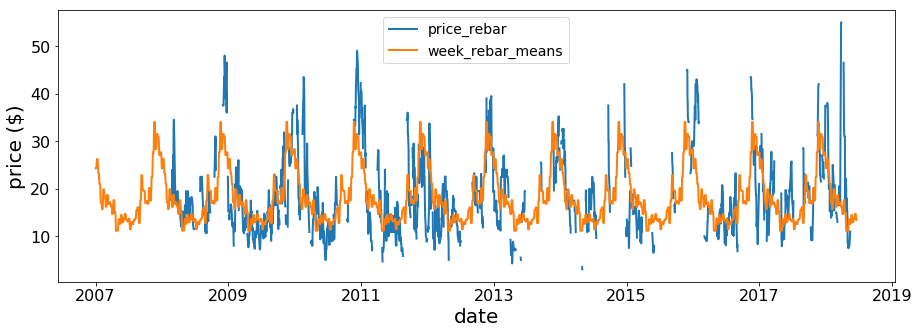

In [16]:
col = 'week'
prod = 'rebar'
prod_col = 'price_' + prod
group_mean = df.groupby([col])[prod_col].mean()

means = df.groupby([col])[prod_col].transform('mean')
df[col+'_'+prod+'_means'] = means

plot_data(df,[prod_col,col+'_'+prod+'_means'])

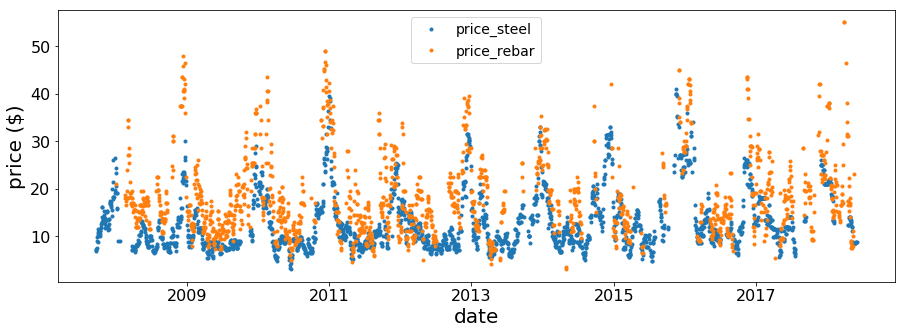

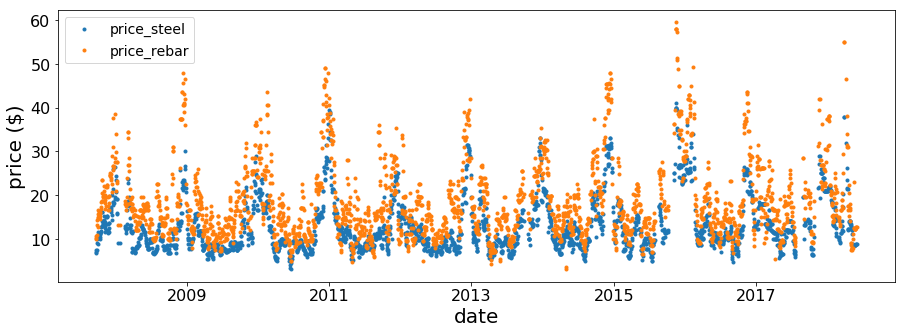

In [17]:
plot_data(df,['price_steel','price_rebar'],linestyle='none',marker='.')
df = interp_ratio(df,'price_steel','price_rebar',normalized=False)
plot_data(df,['price_steel','price_rebar'],linestyle='none',marker='.')

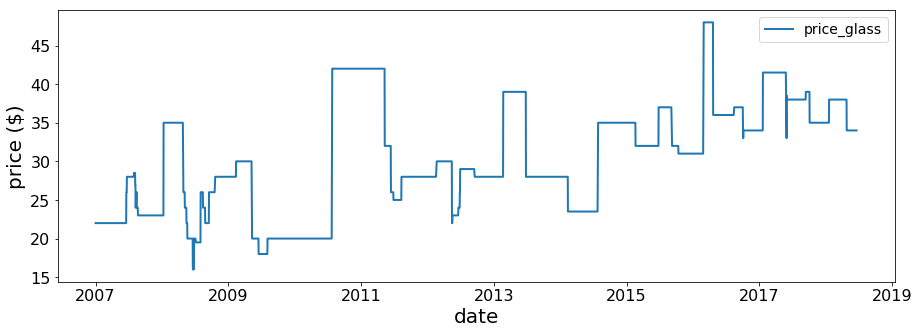

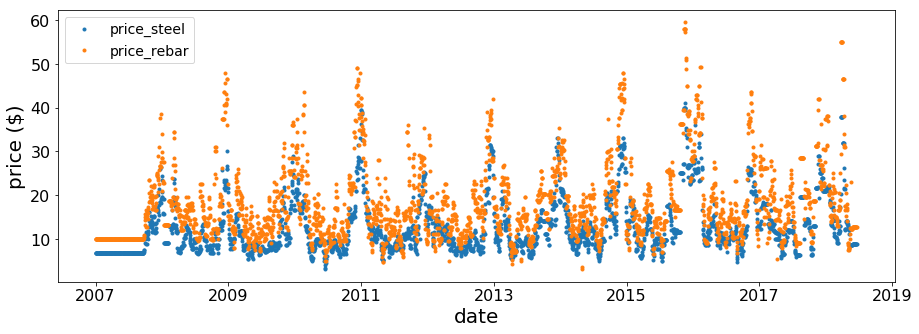

In [18]:
cols = ['price_glass','price_steel','price_rebar','price_concrete','price_plywood']
df = interp_nearest(df,cols)
plot_data(df,'price_glass')
plot_data(df,['price_steel','price_rebar'],linestyle='none',marker='.')

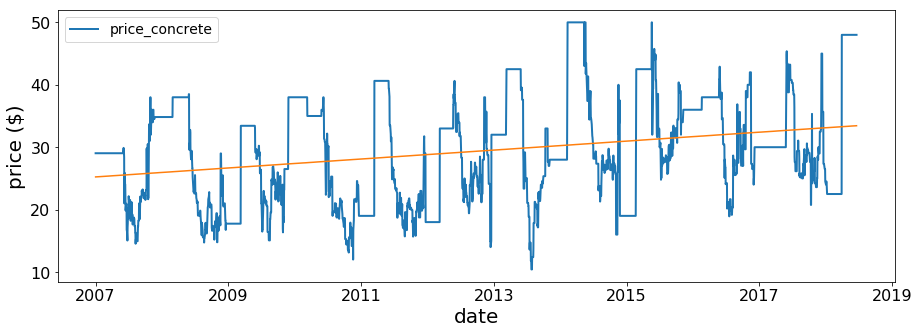

In [19]:
lm = LinearRegression()
mask = df.price_concrete.notnull()
x = np.arange(len(df))
lm.fit(x[mask].reshape(-1,1),df.price_concrete[mask])
plot_data(df,'price_concrete')
plt.plot(df.date,x*lm.coef_+lm.intercept_)